In [ ]:
# default_exp learner

# Learner

> This contains fastai Learner extensions.

In [ ]:
#export
from fastai.learner import * 
from tsai.imports import *

In [ ]:
from tsai.models.InceptionTime import *

In [ ]:
#export
@patch
def save_all(self:Learner, path='export', dls_fname='dls', model_fname='model', learner_fname='learner'):
    
    path = Path(path)
    if not os.path.exists(path): os.makedirs(path)

    # Save the dls
    torch.save(self.dls, path/f'{dls_fname}.pth')

    # Saves the model along with optimizer
    self.model_dir = path
    self.save(model_fname)

    # Export learn without the items and the optimizer state for inference
    self.export(path/f'{learner_fname}.pkl')
    
    print(f'Learner saved:')
    print(f"path          = '{path}'")
    print(f"dls_fname     = '{dls_fname}'")
    print(f"model_fname   = '{model_fname}.pth'")
    print(f"learner_fname = '{learner_fname}.pkl'")
    
    
def load_learner_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner', cpu=True):
    path = Path(path)
    learn = load_learner(path/f'{learner_fname}.pkl', cpu=cpu)
    learn.load(f'{model_fname}')
    dls = torch.load(path/f'{dls_fname}.pth')
    learn.dls = dls
    return learn

In [ ]:
#export
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.set_xlim(0, len(metrics[:, i])-1)
        ax.legend(loc='best')
    plt.show()

In [ ]:
#export
@patch
@delegates(subplots)
def plot_metrics(self: Learner, **kwargs):
    self.recorder.plot_metrics(**kwargs)

In [ ]:
#export
@patch
@delegates(subplots)
def show_probas(self:Learner, figsize=(6,6), ds_idx=1, dl=None, one_batch=False, max_n=None, **kwargs):
    recorder = copy(self.recorder) # This is to avoid loss of recorded values while generating preds
    if one_batch: dl = self.dls.one_batch()
    probas, targets = self.get_preds(ds_idx=ds_idx, dl=[dl] if dl is not None else None)
    if probas.ndim == 2 and probas.min() < 0 or probas.max() > 1: probas = nn.Softmax(-1)(probas)
    if not isinstance(targets[0].item(), Integral): return
    targets = targets.flatten()
    if max_n is not None:
        idxs = np.random.choice(len(probas), max_n, False)
        probas, targets = probas[idxs], targets[idxs]
    fig = plt.figure(figsize=figsize, **kwargs)
    classes = np.unique(targets)
    nclasses = len(classes)
    vals = np.linspace(.5, .5 + nclasses - 1, nclasses)[::-1]
    plt.vlines(.5, min(vals) - 1, max(vals), color='black', linewidth=.5)
    cm = plt.get_cmap('gist_rainbow')
    color = [cm(1.* c/nclasses) for c in range(1, nclasses + 1)][::-1]
    class_probas = np.array([probas[i,t] for i,t in enumerate(targets)])
    for i, c in enumerate(classes):
        plt.scatter(class_probas[targets == c] if nclasses > 2 or i > 0 else 1 - class_probas[targets == c],
                    targets[targets == c] + .5 * (np.random.rand((targets == c).sum()) - .5), color=color[i], edgecolor='black', alpha=.2, s=100)
        if nclasses > 2: plt.vlines((targets == c).float().mean(), i - .5, i + .5, color='r', linewidth=.5)
    plt.hlines(vals, 0, 1)
    plt.ylim(min(vals) - 1, max(vals))
    plt.xlim(0,1)
    plt.xticks(np.linspace(0,1,11), fontsize=12)
    plt.yticks(classes, fontsize=12)
    plt.title('Predicted proba per true class' if nclasses > 2 else 'Predicted class 1 proba per true class', fontsize=14)
    plt.xlabel('Probability', fontsize=12)
    plt.ylabel('True class', fontsize=12)
    plt.grid(axis='x', color='gainsboro', linewidth=.2)
    plt.show()
    self.recorder = recorder

In [ ]:
from tsai.data.all import *
from tsai.models.all import *
dsid = 'OliveOil'
X, y, splits = get_UCR_data(dsid, parent_dir='./data/UCR/', verbose=True, on_disk=True, return_split=False)
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128])
model = FCN(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(2, lr_max=1e-3)

Dataset: OliveOil
X      : (60, 1, 570)
y      : (60,)
splits : ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]) 



epoch,train_loss,valid_loss,accuracy,time
0,1.424509,1.539864,0.133333,00:08
1,1.421399,1.493935,0.133333,00:06


In [ ]:
learn.save_all()
del learn

Learner saved:
path          = 'export'
dls_fname     = 'dls'
model_fname   = 'model.pth'
learner_fname = 'learner.pkl'


In [ ]:
learn = load_learner_all()

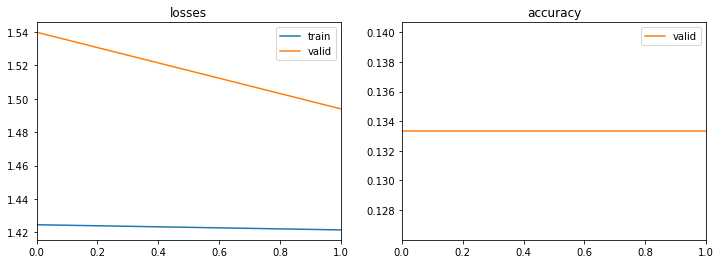

In [ ]:
learn.plot_metrics()

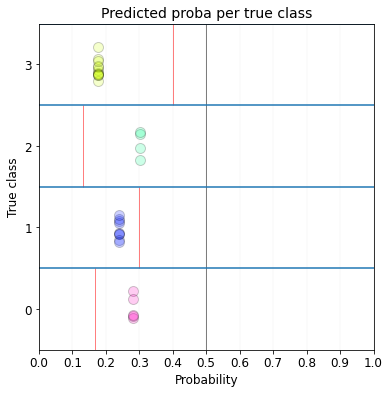

In [ ]:
learn.show_probas()

In [ ]:
learn.recorder.values

[(#3) [1.4245091676712036,1.5398637056350708,0.13333334028720856],
 (#3) [1.4213988780975342,1.4939348697662354,0.13333334028720856]]

In [ ]:
#hide
out = create_scripts()
beep(out)

<IPython.core.display.Javascript object>

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nacho/Documents/Machine_Learning/Jupyter_Notebooks/timeseries/nbs/.~008_learner.ipynb'